### Let's use a benchmark BEM problem to test if the current functions are working correctly.

In [1]:
%matplotlib widget

In [2]:
from acousticBEM.AcousticProperties import *
from acousticBEM.BoundaryData import *
from acousticBEM.ExampleBoundaries import *
from acousticBEM.Geometry import *
from acousticBEM.HelmholtzIntegrals2D import *
from acousticBEM.HelmholtzSolver import *
from acousticBEM.HelmholtzSolver2D import *

In [3]:
import numpy as np
from numpy import log, sin, cos, arctan2, pi, mean, dot
from numpy.linalg import norm, solve
from scipy.special import roots_legendre, hankel1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from misc.add_funs_mod import *
import meshio
import gmsh
import sys

---

### Original field (Analytic)

In [19]:
# Screen width and height
upper_grid_size = 15
lower_grid_size = -upper_grid_size
ngrid_pts = 60

grid_vec = np.linspace(lower_grid_size,upper_grid_size,num=ngrid_pts)
X,Y = np.meshgrid(grid_vec,grid_vec)

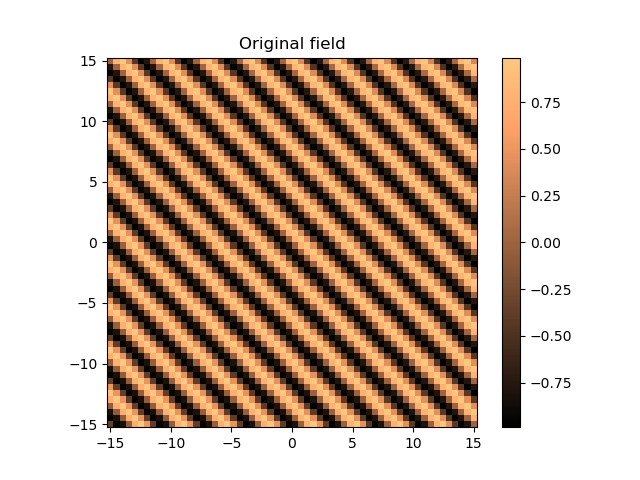

In [22]:
# Define the incident wave-field, U_i
k = 2.5
angle = np.pi/4
ui_fun = lambda k, x, y, theta : np.sin(k *(x*np.cos(theta)+y* np.sin(theta)))

# Plot the surface

fig, ax = plt.subplots()
plot = ax.pcolormesh(X, Y, ui_fun(k,X,Y, angle), edgecolor="none",cmap="copper")
ax.axis('equal')
ax.set_aspect('equal', 'box')

cbar = fig.colorbar(plot,ax=ax)
plt.title(r"Original field")
plt.show()

---

### BEM alternative

In [6]:
# GMSH mesh geometry generation
create_square_geo(lower_grid_size, upper_grid_size, 0.1, ngrid_pts)

In [7]:
gmsh.initialize()
gmsh.open("simple_square_bound.geo")
gmsh.model.mesh.generate(1)  # 1D mesh

gmsh.write("simple_square_bound.msh")
gmsh.finalize()

In [8]:
fname = "simple_square_bound.msh"
mesh = meshio.read(fname)

In [26]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = read_geo_gmsh(fname, [0,1,2,3], None)
elems = np.flip(elems[:, ::-1], axis=0) # For interior problems
x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T

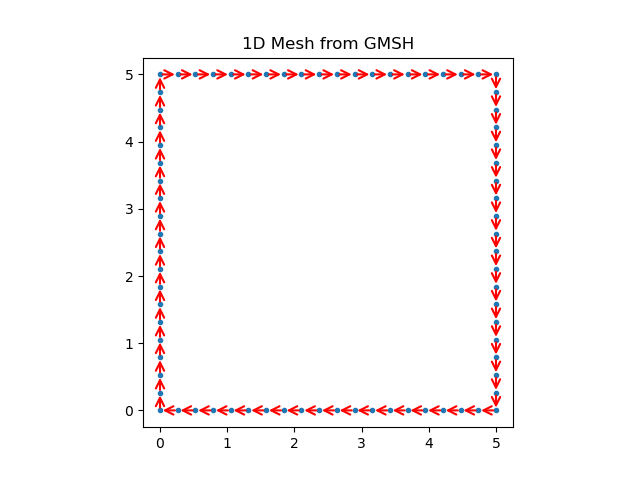

In [25]:
# Plot the surface
plt.close('all')

fig, ax = plt.subplots()
plot = ax.plot(coords[:,0], coords[:,1],".")

for elem in elems:
    i, j = elem  # indices of connected points
    x0, y0 = coords[i]
    x1, y1 = coords[j]
    dx, dy = x1 - x0, y1 - y0
    
    ax.annotate("",
                xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(arrowstyle="->", color='red', lw=1.5),
                size=15)

    
ax.set_aspect('equal', 'box')
plt.title(r"1D Mesh from GMSH")
plt.show()

In [11]:
u_boundary = np.zeros(x_m.shape[0])
u_boundary[id_dir] = ui_fun(k,x_m,y_m)

---


In [12]:
solver = HelmholtzSolver2D( aVertex = coords, aElement = elems, c = 344.0, density = 1.205)

In [13]:
# Dirichlet conditions at every element, thus alpha is flled with 1 and beta with 0
boundaryCondition = BoundaryCondition(solver.aElement.shape[0])
boundaryCondition.alpha.fill(1.0) # Dirichlet
boundaryCondition.beta.fill(0.0) # Neumann
boundaryCondition.f[:] = u_boundary

boundaryIncidence = BoundaryIncidence(solver.aElement.shape[0])
boundaryIncidence.phi.fill(0.0)
boundaryIncidence.v.fill(0.0)

In [14]:
X_flat = X.flatten()
Y_flat = Y.flatten()
eval_points = np.column_stack((X_flat, Y_flat))

interiorIncidentPhi = np.zeros(eval_points.shape[0], dtype=np.complex64)

In [15]:
boundarySolution = solver.solveInteriorBoundary(k, boundaryCondition, boundaryIncidence)
interiorPhi = solver.solveInterior(boundarySolution, interiorIncidentPhi, eval_points)
#print("Test Problem 1")
#print("==============\n")
#print(boundarySolution)
#printInteriorSolution(boundarySolution, interiorPhi)

In [16]:
boundarySolution.aPhi.real

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.78039306,
        2.12994814,  2.90298462,  2.89026284,  2.09522605,  0.73306888,
       -0.82750988, -2.16410446, -2.91493511, -2.87677288, -2.05994701,
       -0.68554991,  0.8744067 ,  2.19768548,  2.92611098,  2.86251831,
        2.02412057,  0.63784873, -0.92107123, -1.63206339, -1.63206339,
       -1.63206339, -1.63206339, -1.63206339, -1.63206339, -1.63206339,
       -1.63206339, -1.63206339, -1.63206339, -1.63206339, -1.63206339,
       -1.63206339, -1.63206339, -1.63206339, -1.63206339, -1.63206339,
       -1.63206339, -1.63206339, -0.92107123,  0.63784873,  2.02412057,
        2.86251831,  2.92611098,  2.19768548,  0.8744067 , -0.68554991,
       -2.05994701, -2.87677288, -2.91493511, -2.16410446, -0.82

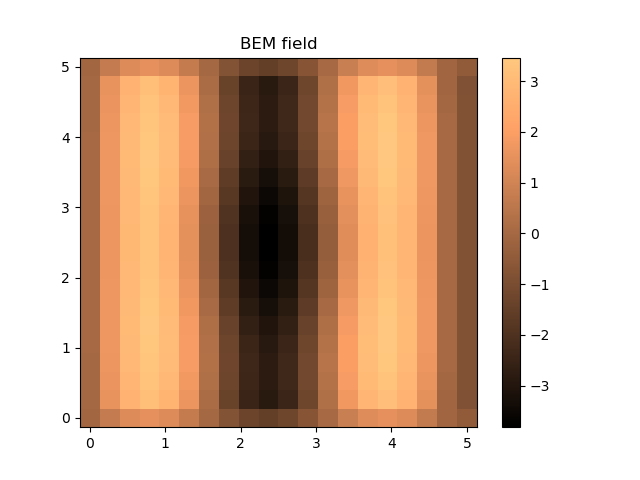

In [17]:
bem_field = (interiorPhi.reshape((Y.shape))).real

fig2, ax2 = plt.subplots()
plot = ax2.pcolormesh(X, Y, bem_field , edgecolor="none",cmap="copper")
ax.axis('equal')
ax.set_aspect('equal', 'box')

cbar = fig2.colorbar(plot,ax=ax2)
plt.title(r"BEM field")
plt.show()

---

In [18]:
%%time
Gmat, Hmat = assem(coords,elems,k,"internal")

CPU times: total: 10.4 s
Wall time: 10.4 s


In [19]:
q_boundary = solve(Gmat, Hmat.dot(u_boundary))

In [20]:
%%time
sol_af = eval_sol(eval_points, coords, elems, u_boundary, q_boundary, k, "internal")

CPU times: total: 51.1 s
Wall time: 51.5 s


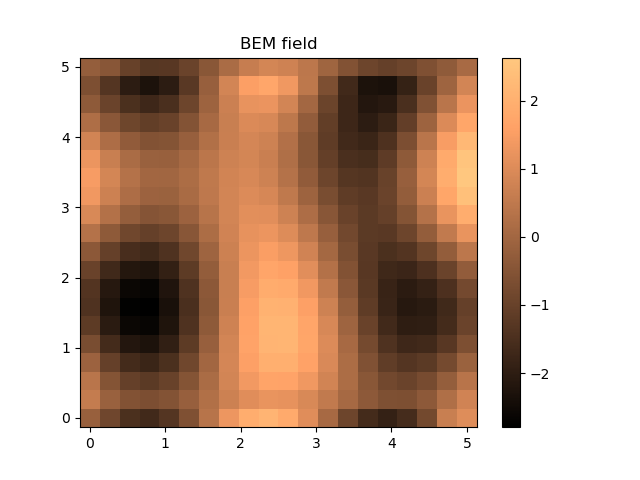

In [21]:
bem_field_af = (sol_af.reshape((Y.shape))).real

fig2, ax2 = plt.subplots()
plot = ax2.pcolormesh(X, Y, bem_field_af , edgecolor="none",cmap="copper")
ax.axis('equal')
ax.set_aspect('equal', 'box')

cbar = fig2.colorbar(plot,ax=ax2)
plt.title(r"BEM field")
plt.show()